In [1]:


import numpy as np
import pandas

import matplotlib.pyplot as plt
import argparse
import os

# import yaml
import json

# def load_images(image_dir: str) -> np.ndarray:
from PIL import Image

dataset_path = "/home/dpastorm/copy_no_blend/ortho_nominal_2024-08-01_17-07-04"
dataset_path = "/home/dpastorm/Projects/lunamaps/lunasynth/tmp/datasets/minimal_2024-08-21_15-29-14"

In [19]:
# find all rendering cases, all terrains

meshes = {}
terrains = []
rendering_cases = []

total_rocks = 0
total_craters = 0
nterrains = 0
craters_list = []
for mesh_folder in os.listdir(dataset_path):
    if not mesh_folder.startswith("mesh_"):
        continue
    mesh_path = os.path.join(dataset_path, mesh_folder)
    mesh_name = mesh_folder.split("_")[1]
    meshes[mesh_name] = {"path": mesh_path}

    for terrain_folder in os.listdir(mesh_path):
        if not terrain_folder.startswith("terrain_"):
            continue
        terrain_path = os.path.join(mesh_path, terrain_folder)
        terrain_index = int(terrain_folder.split("_")[1])
        terrains.append({"path": terrain_path})
        nterrains += 1

        rock_field_path = os.path.join(terrain_path, "rock_field.csv")
        with open(rock_field_path, "r") as f:
            rock_field = pandas.read_csv(f)
        nrocks = len(rock_field)
        total_rocks += nrocks

        crater_field_path = os.path.join(terrain_path, "crater_field.csv")
        with open(crater_field_path, "r") as f:
            crater_field = pandas.read_csv(f)
        ncraters = len(crater_field)
        total_craters += ncraters
        craters_list.append(ncraters)

        # read params.json
        params_json_path = os.path.join(terrain_path, "params.json")
        with open(params_json_path, "r") as f:
            params = json.load(f)

        for case in params["cases_list"]:
            case_data = {"sun/elevation": case["sun/elevation"], 
                         "sun/azimuth": case["sun/azimuth"],
                         "case_id": case["case_id"],
                         "terrain_index": terrain_index,
                         "mesh_name": mesh_name,
                         "terrain_path": terrain_path,}
            for file in case["files"]:
                if not os.path.exists(os.path.join(terrain_path, file)):
                    print(f"file {file} does not exist")
                    continue
                if "rgb" in file:
                    case_data["rgb_"] = file
                elif "segmentation_color_" in file:
                    case_data["segmentation_color"] = file                
            rendering_cases.append(case_data)
df = pandas.DataFrame(rendering_cases)
            
print(f"nterrains  {nterrains}")
print(f"total rocks: {total_rocks}, per terrain: {total_rocks/nterrains}")
print(f"total craters: {total_craters}, per terrain: {total_craters/nterrains}")


nterrains  1
total rocks: 1967, per terrain: 1967.0
total craters: 37506, per terrain: 37506.0


case: 94.3937571651555, -89.96231953044014, 192.0
case: -49.10165687512742, 9.26127905187542, 192.0


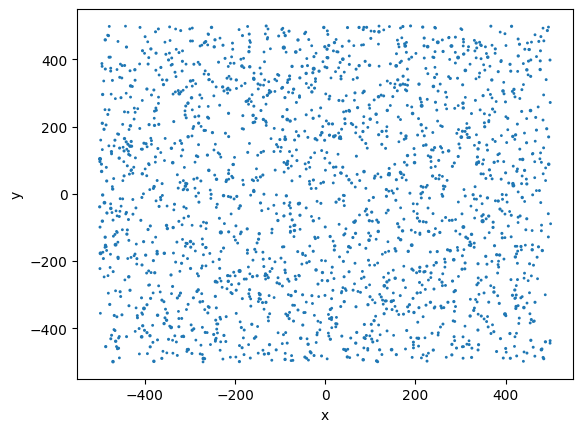

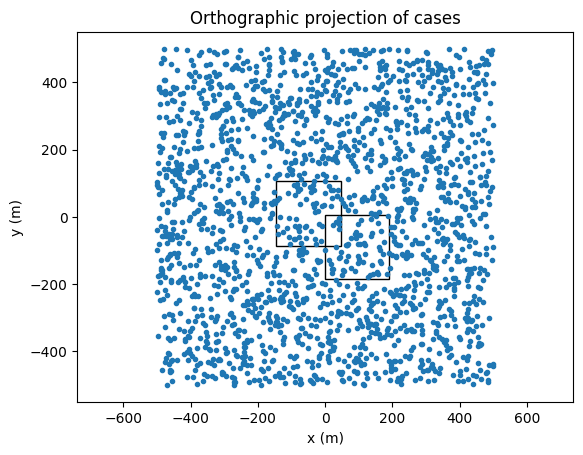

case: 94.3937571651555, -89.96231953044014, 192.0


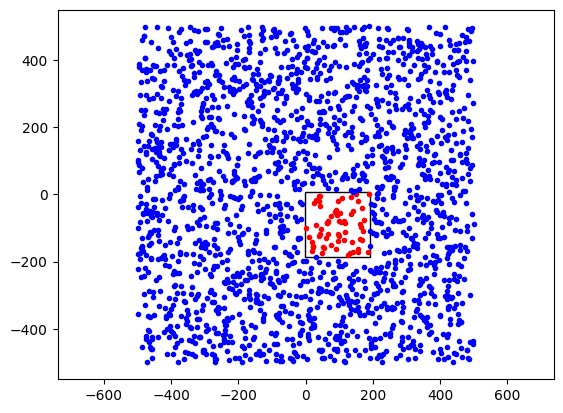

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
rock_field = pd.read_csv(terrains[0]["path"] + "/rock_field.csv")
rock_field.plot.scatter(x='x', y='y', s=rock_field['diameter'])

# for terrain in terrains:
# plot the camera/x, camera/y, with a rectangle of size camera/ortho_scales
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig, ax = plt.subplots()
for case in params['cases_list']:
    print(f"case: {case['camera/x']}, {case['camera/y']}, {case['camera/ortho_scale']}")
    ax.add_patch(patches.Rectangle((case['camera/x'] - case['camera/ortho_scale']/2, case['camera/y'] - case['camera/ortho_scale']/2), case['camera/ortho_scale'], case['camera/ortho_scale'], edgecolor="black", facecolor="none",))
plt.axis("equal")
ax.plot(rock_field['x'], rock_field['y'], '.')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("Orthographic projection of cases")
plt.show()



case: 94.3937571651555, -89.96231953044014, 192.0


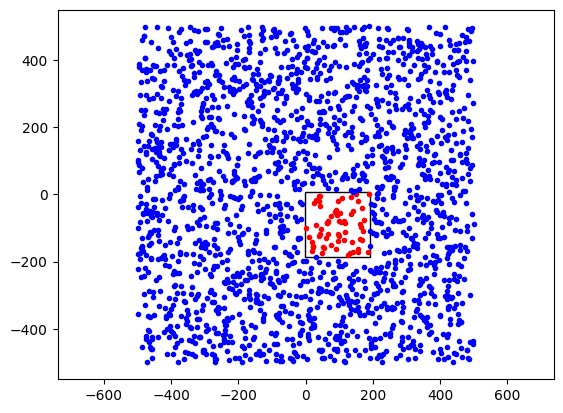

In [12]:
# plot in red the rocks inside the first case
fig, ax = plt.subplots()
case = params['cases_list'][0]
print(f"case: {case['camera/x']}, {case['camera/y']}, {case['camera/ortho_scale']}")
ax.add_patch(patches.Rectangle((case['camera/x'] - case['camera/ortho_scale']/2, case['camera/y'] - case['camera/ortho_scale']/2), case['camera/ortho_scale'], case['camera/ortho_scale'], edgecolor="black", facecolor="none",))
plt.axis("equal")
for i, rock in rock_field.iterrows():
    if rock['x'] > case['camera/x'] - case['camera/ortho_scale']/2 and rock['x'] < case['camera/x'] + case['camera/ortho_scale']/2 and rock['y'] > case['camera/y'] - case['camera/ortho_scale']/2 and rock['y'] < case['camera/y'] + case['camera/ortho_scale']/2:
        ax.plot(rock['x'], rock['y'], 'r.')
    else:
        ax.plot(rock['x'], rock['y'], 'b.')

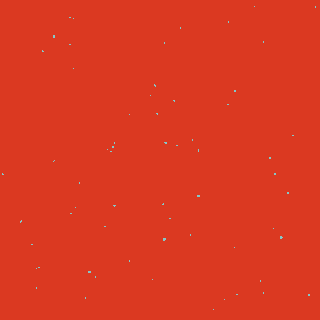

In [18]:
# display the mask image for the first case
case = params['cases_list'][0]
for f in case['files']:
    if "segmentation_color_" in f:
        mask_image_path = f
mask_image = Image.open(os.path.join(terrain_path, mask_image_path))
from PIL import Image
display(mask_image)

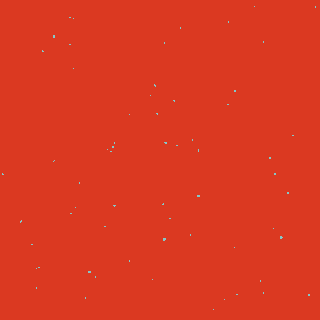

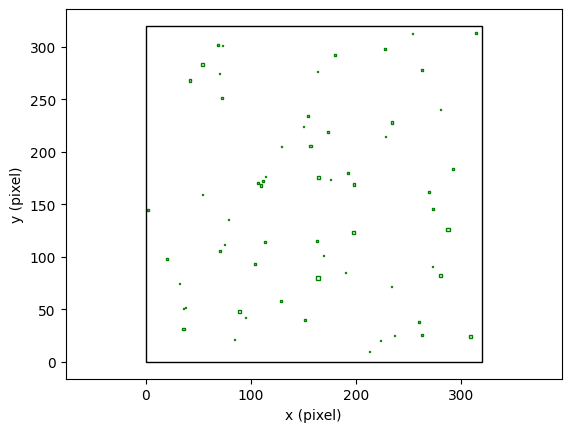

In [27]:
# compute the rocks in pixel space
rock_field['x_pixel'] = (rock_field['x'] - case['camera/x'] + case['camera/ortho_scale']/2) / case['camera/ortho_scale'] * mask_image.size[0]
rock_field['y_pixel'] = (rock_field['y'] - case['camera/y'] + case['camera/ortho_scale']/2) / case['camera/ortho_scale'] * mask_image.size[1]
rock_field['diameter_pixel'] = rock_field['diameter'] / case['camera/ortho_scale'] * mask_image.size[0]
rock_field['diameter_pixel'] = rock_field['diameter_pixel'].astype(int)
rock_field['x_pixel'] = rock_field['x_pixel'].astype(int)
rock_field['y_pixel'] = rock_field['y_pixel'].astype(int)
rock_field['diameter_pixel'] = rock_field['diameter_pixel'].astype(int)

# plot the rocks in pixel space
fig, ax = plt.subplots()
display(mask_image)
for i, rock in rock_field.iterrows():
    # check if the rock is inside the image
    if rock['x_pixel'] < 0 or rock['x_pixel'] >= mask_image.size[0] or rock['y_pixel'] < 0 or rock['y_pixel'] >= mask_image.size[1]:
        continue
    ax.add_patch(patches.Rectangle((rock['x_pixel']-rock['diameter_pixel']/2, rock['y_pixel']-rock['diameter_pixel']/2), rock['diameter_pixel'], rock['diameter_pixel'], edgecolor="green", facecolor="none",))
ax.add_patch(patches.Rectangle((0, 0), mask_image.size[0], mask_image.size[1], edgecolor="black", facecolor="none",))
ax.set_xlabel("x (pixel)")
ax.set_ylabel("y (pixel)")
plt.axis("equal")
plt.show()


(array([28., 51., 32., 29., 43., 32., 42., 27., 41., 41., 49., 33., 31.,
        29., 43., 43., 41., 64., 40., 45.]),
 array([139550. , 143084.3, 146618.6, 150152.9, 153687.2, 157221.5,
        160755.8, 164290.1, 167824.4, 171358.7, 174893. , 178427.3,
        181961.6, 185495.9, 189030.2, 192564.5, 196098.8, 199633.1,
        203167.4, 206701.7, 210236. ]),
 <BarContainer object of 20 artists>)

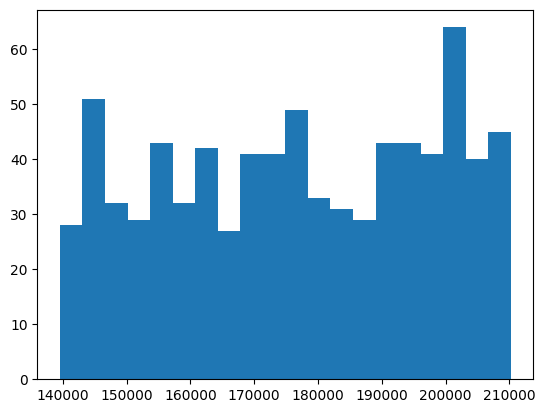

In [14]:
# histogram of craters_list
plt.hist(craters_list, bins=20)

array([[<Axes: title={'center': 'sun/elevation'}>]], dtype=object)

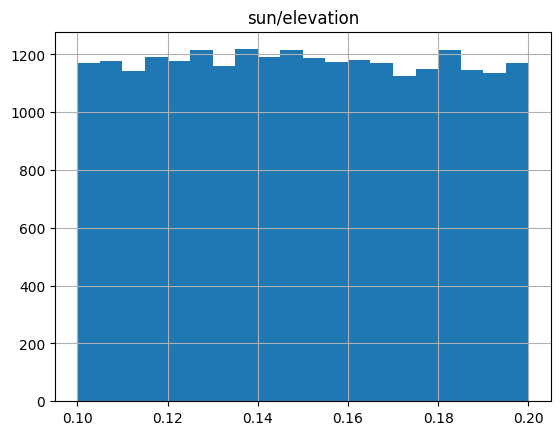

In [23]:
# histogram of sun elevation using pandas
df.hist(column="sun/elevation", bins=20)

In [21]:

def calculate_percentage_below_threshold(image_path, threshold):
    # Open the image file
    with Image.open(image_path) as img:
        # Convert the image to grayscale
        grayscale_img = img.convert("L")
        # Convert the grayscale image to a numpy array
        img_array = np.array(grayscale_img)

    # Calculate the total number of pixels
    total_pixels = img_array.size

    # Count the number of pixels below the threshold
    pixels_below_threshold = np.sum(img_array < threshold)

    # Calculate the percentage
    percentage_below_threshold = (pixels_below_threshold / total_pixels) * 100

    return percentage_below_threshold

# for every rgb image, calculate the percentage of pixels below a threshold
threshold = 0.1
percentages = []
for i, row in df.iterrows():
    rgb_path = os.path.join(row["terrain_path"], row["rgb_"])
    percentage = calculate_percentage_below_threshold(rgb_path, threshold)
    percentages.append(percentage)
df["percentage_below_threshold"] = percentages


<Axes: xlabel='percentage_below_threshold', ylabel='Count'>

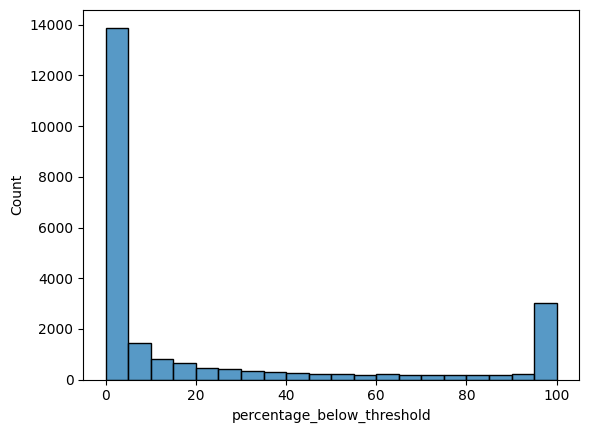

In [25]:
# histogram of percentage_below_threshold, using seaborn
import seaborn as sns
sns.histplot(df, x="percentage_below_threshold", bins=20)

In [27]:
# count how many of them are above 98%
nabove = len(df[df["percentage_below_threshold"] > 98])
print(f"number of images with more than 98% of pixels below {threshold}: {nabove}, in percentage: {nabove/len(df)*100}")


number of images with more than 98% of pixels below 0.1: 2807, in percentage: 11.93452380952381
